# Unnormalised Mixture of two Gaussians

Previously, in notebooks 1 & 2, we considered the **normalised** mixture of gaussian model family:

$$ \phi(u, z; \theta) = (1-z) \frac{1}{\sqrt{2 \pi} \theta} e^{-\frac{u^2}{2 \theta^2}} + z \frac{1}{\sqrt{2 \pi} \sigma_1} e^{-\frac{u^2}{2 \sigma_1^2}} $$

Below, we consider the **unnormalised** mixture of gaussian model family, with an additional scaling parameter $c$:

\begin{align}
\phi(u, z; \theta, c) & = e^{-c} \left( (1-z) e^{-\frac{u^2}{2 \theta^2}} + z e^{-\frac{u^2}{2 \sigma_1^2}} \right) \\
                   & = e^{-c} \sqrt{2 \pi} \left( (1-z)  \theta \mathcal{N}(u, \theta) + 
                                            z \sigma_1 \mathcal{N}(u;\sigma_1) \right)
\end{align}

where $z \sim \mathcal{Ber}(\frac{1}{2})$.

(note that the first family is not nested in the latter - you would need two scaling parameters, one for each unnormalised gaussian).

Integrating this family yields the partition function:

$$ Z(\theta, c) = e^{-c}\sqrt{2\pi}( \theta + \sigma_1 ) $$

Therefore, the corresponding normalised family has the form:

\begin{align} 
    p_m(u; \theta) & = \frac{\sum_{z=0}^1\phi(u, z, \theta, c)}{Z(\theta, c)} \\
                 & = \frac{e^{-c}\sqrt{2 \pi} \left( \theta \mathcal{N}(u, \theta) + 
                                            \sigma_1 \mathcal{N}(u;\sigma_1) \right)}{Z(\theta, c)} \\
                 & = \frac{\theta}{\theta + \sigma_1} \mathcal{N}(u; 0, \theta) +
                     \frac{\sigma_1}{\theta + \sigma_1} \mathcal{N}(u; 0, \sigma_1)
\end{align}

this last formula gives us a way to easily generate synthetic data. fixing $\theta = \sigma_0$, we get:

\begin{align} 
        p_x(u)  =  \mathbb{E}_{w}\left( (1-w) \mathcal{N}(u; 0, \sigma_0) + w \mathcal{N}(u; 0, \sigma_1) \right))
\end{align}

 where $ w \sim \mathcal{Ber}(\frac{\sigma_1}{\sigma_1 + \sigma_0}) $.
 
So, if $\sigma_0 = 4$ and $\sigma_1^2 = 1$, then we can toss a biased coin $ w \sim \mathcal{Ber}(\frac{1}{5}) $, and then draw a data point $x$ from the corresponding gaussian.

We can also calculate in advance the optimal value of $c$, call it $c_0$, that we want to estimate. $c_0$ should satisfy:

$$ 
Z(\sigma_0, c_0) = 1 \\
\Rightarrow \ \ \ \ \ c_0 = \frac{1}{2}\log(2\pi) + \log(\sigma_0 + \sigma_1) 
$$

For the values $\sigma_0 = 4$ and $\sigma_1^2 = 1$, this implies $c_0 \approx 2.5283764456387727$.

## Applying variational EM-type algorithm to the unnormalised model

In the previous notebooks, we demonstrated how to apply a variational EM type algorithm to the normalised MoG. The mathematical derivations in those notebooks mostly transfer to the unnormalised case. In fact, the only difference is that we need to plug in a different expression for:

$$ \nabla_{\theta} \log(\phi(u, z; \theta)) $$

the derivation for this term is very similar to the normalised case. The end result is:

$$ \nabla_{\theta} \log(\phi(u, z; \theta)) = \left[ -1, \ (1- z) \frac{u^2}{\theta^3} \right]^T $$

In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [2]:
import numpy as np
import pdb

# my code
from distribution import PolynomialSigmoidBernoulli, GaussianNoise
from gaussian_mixture_analytic_expectations import *
from latent_nce_optimiser import LatentNCEOptimiserWithAnalyticExpectations, LatentNCEOptimiser
from latent_variable_model import MixtureOfTwoUnnormalisedGaussians

from matplotlib import pyplot as plt
from matplotlib import rc
from numpy import random as rnd

%matplotlib inline
rc('lines', linewidth=3)
rc('font', size=18)
rc('legend', fontsize=18)

In [3]:
# For reproducibility
rng = rnd.RandomState(1083463236)

In [4]:
# mixing proportions: 0.5 and 0.5
# mean0 = mean1 = 0
sigma1 = 1
sigma0 = 4  # (parameter of interest)

n = 10000 # number of data points
nz = 1  # number of latent samples per datapoint
nu = 1 # nu is the ratio of noise to data samples in NCE
c0 = 2.5283764456387727  # true value of normalising constant
true_theta = np.array([c0, sigma0])

theta0 = np.array([0, 0.5])
alpha0 = np.array([-0.1,-0.1,-0.1])# initial theta

In [5]:
true_data_dist = MixtureOfTwoUnnormalisedGaussians(theta=true_theta, sigma1=sigma1)
X = true_data_dist.sample(n) # generate data

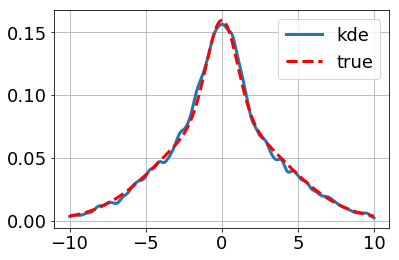

In [6]:
true_data_dist.plot_sample_density_against_true_density(X, figsize=(6,4))

In [7]:
model = MixtureOfTwoUnnormalisedGaussians(np.array([0, 0.5]), sigma1=sigma1)
noise = GaussianNoise(mean=0, std = sigma0)
var_dist = PolynomialSigmoidBernoulli(alpha=np.array([0,0,0]))

In [8]:
# E(r(x, z))
E1 = E_r
# E(log(psi_1(x, z)))
E2 = E_log_psi_1
# E((psi_1(x, z) - 1) / psi_1(x, z))
E3 = E_psi_1_ratio_times_grad_log_theta
# E(grad_theta(log(phi(u,z)) r(u, z))
E4 = E_r_times_grad_log_theta
# gradient_alpha(E(log(psi_1(x, z)))
E5 = grad_wrt_alpha_of_E_log_psi_1

In [9]:
mc_optimiser = LatentNCEOptimiser(model, noise, var_dist, n, nu=nu, latent_samples_per_datapoint=nz)

In [10]:
optimiser = LatentNCEOptimiserWithAnalyticExpectations(model, noise, var_dist, n,
                                                       E1, E2, E3, E4, E5, 
                                                       nu=nu, latent_samples_per_datapoint=nz, eps = 10**-20)
Y = optimiser.Y

## NCE objective function

In [11]:
theta_ones = np.arange(0.01, 8, 0.1)
theta_zeros = np.arange(0.01, 4, 0.1) 
n_theta = len(theta_ones)
n_c = len(theta_zeros)

# unnormalised model with z integrated out
def phi_m(u):
    term_1 = np.exp(-u**2/ (2*(model.theta[1]**2)))
    term_2 = np.exp(-u**2/(2*sigma1**2))
    return (np.exp(-model.theta[0]) * (term_1 + term_2)).reshape(-1)

def h(u):
    return np.log(phi_m(u)/noise(u))

def h_norm(u):
    return np.log(model.normalised_and_marginalised_over_z(u)/noise(u)) # for comparison

J = np.zeros((n_theta, n_c))
J_norm = np.zeros(n_theta) # objective evaluated on normalised model, for comparison

for k in range(n_theta):
    model.theta[1] = theta_ones[k]
    
    a0 = 1 + nu*np.exp(-h_norm(X)) 
    a1 = 1 + (1/nu)*np.exp(h_norm(Y))
    J_norm[k] = -np.mean(np.log(a0)) - nu*np.mean(np.log(a1))
                  
    for m in range(n_c):
        model.theta[0] = theta_zeros[m]
        
        a0 = 1 + nu*np.exp(-h(X))
        a1 = 1 + (1/nu)*np.exp(h(Y))
        J[k, m] = -np.mean(np.log(a0)) - nu*np.mean(np.log(a1))

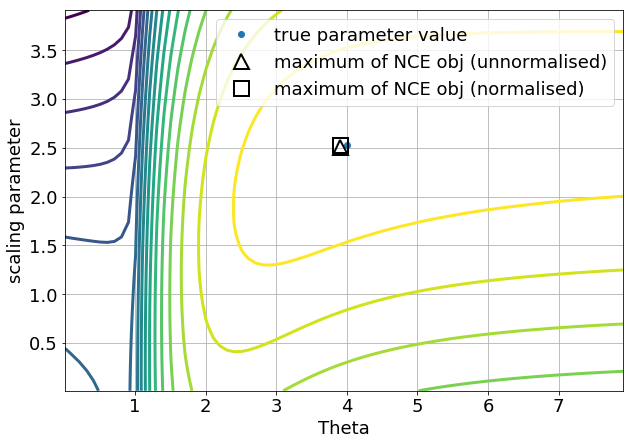

In [12]:
fig = plt.figure(figsize=(10,7))

XX, YY = np.meshgrid(theta_ones, theta_zeros)
plt.contour(XX, YY, J.T, 15)

plt.plot(sigma0, c0,'o', label='true parameter value')

index = np.argmax(J) # this is the index for the flattened array
row = int(index/n_c)
column = index % n_c

plt.plot(theta_ones[row], theta_zeros[column], marker='^', markersize=15, fillstyle='none', 
         markeredgewidth=2, c='k', linestyle='none', label='maximum of NCE obj (unnormalised)')

index2 = np.argmax(J_norm) # this is the index for the flattened array

plt.plot(theta_ones[index2], c0, marker='s', markersize=15, fillstyle='none', 
         markeredgewidth=2, c='k', linestyle='none', label='maximum of NCE obj (normalised)')

plt.xlabel('Theta')
plt.ylabel('scaling parameter')

plt.grid()
lgd = plt.legend(loc='best', numpoints=1)

## First lower bound

In order to obtain a lower bound on the first term in the NCE objective function, we need to specify a variational posterior distribution that can 'fill in' the missing values $z$.

As in the sanity check code, we use $p(z \ | \ x)$, which can be computed as:

\begin{align}
q_u(z=0 \ | \ u) & = p(z=0 \ | \ u) \\
             & = \frac{1}{1 + \exp(\frac{-u^2}{2} (\frac{1}{\sigma_1^2} + \frac{1}{\sigma_0^2}) )}
\end{align}

In [13]:
# Let's compute values of objective for fixed variation q, with alpha=sigma0
var_dist.alpha = np.array([0, 0, 17/32])
ZX, ZY = var_dist.sample(nz, X), var_dist.sample(nz, Y)

J1 = np.zeros((n_theta, n_c))
J1_mc = np.zeros((n_theta, n_c))
for k in range(n_theta):
    model.theta[1] = theta_ones[k]
    for m in range(n_c):
        model.theta[0] = theta_zeros[m]
        J1[k, m] = optimiser.compute_J1(X)
        J1_mc[k, m] = mc_optimiser.compute_J1(X, ZX, ZY)

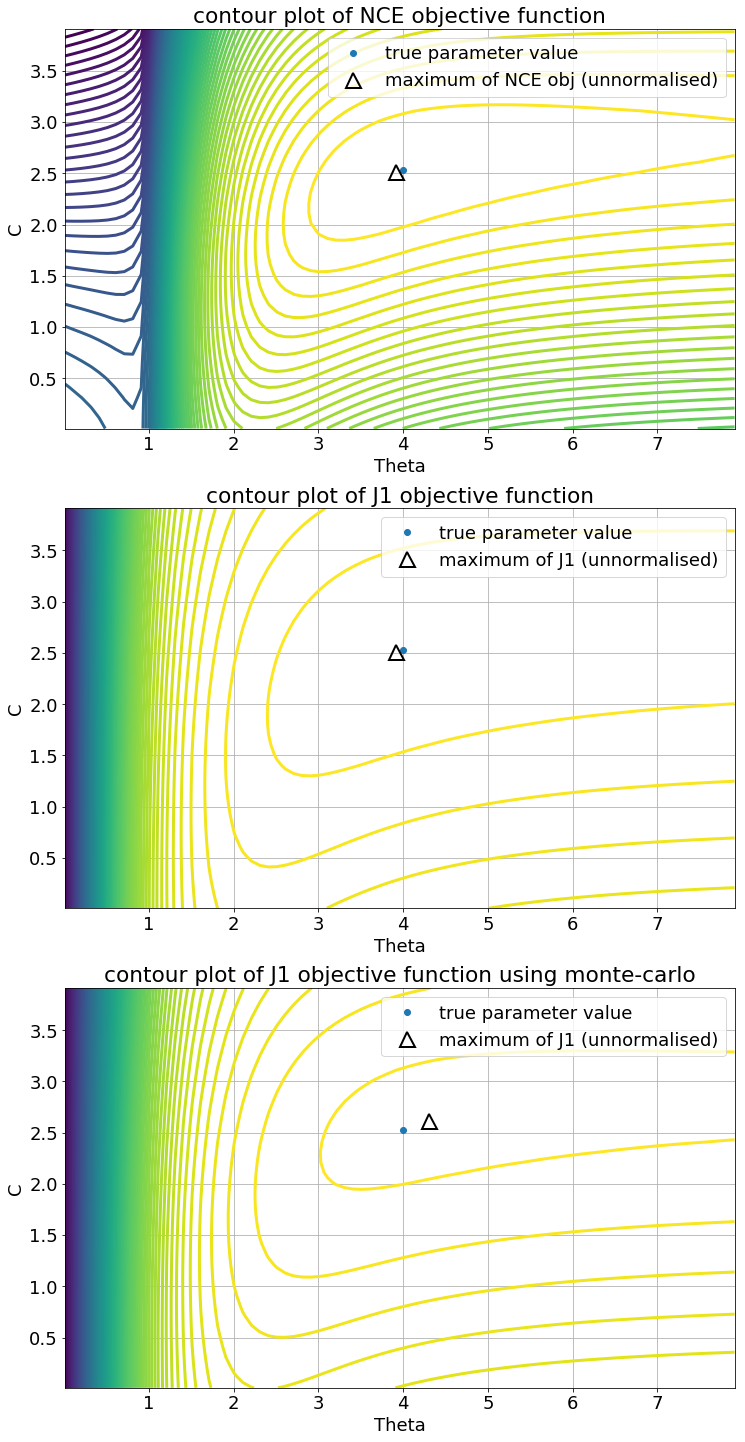

In [14]:
fig, ax = plt.subplots(3, 1, figsize=(12,25))

XX, YY = np.meshgrid(theta_ones, theta_zeros)

# Plot true NCE objective function
ax[0].contour(XX, YY, J.T, 100)
ax[0].plot(sigma0, c0,'o', label='true parameter value')
ax[0].plot(theta_ones[row], theta_zeros[column], marker='^', markersize=15, fillstyle='none', 
         markeredgewidth=2, c='k', linestyle='none', label='maximum of NCE obj (unnormalised)')

# Plot lower bound J1 objective function
ax[1].contour(XX, YY, J1.T, 100)
ax[1].plot(sigma0, c0,'o', label='true parameter value')

# Plot lower bound J1 objective function
ax[2].contour(XX, YY, J1_mc.T, 100)
ax[2].plot(sigma0, c0,'o', label='true parameter value')

index3 = np.argmax(J1) # this is the index for the flattened array
row3 = int(index3/n_c)
column3 = index3 % n_c
ax[1].plot(theta_ones[row3], theta_zeros[column3], marker='^', markersize=15, fillstyle='none', 
         markeredgewidth=2, c='k', linestyle='none', label='maximum of J1 (unnormalised)')

index4 = np.argmax(J1_mc) # this is the index for the flattened array
row4 = int(index4/n_c)
column4 = index4 % n_c
ax[2].plot(theta_ones[row4], theta_zeros[column4], marker='^', markersize=15, fillstyle='none', 
         markeredgewidth=2, c='k', linestyle='none', label='maximum of J1 (unnormalised)')

ax[0].set_title('contour plot of NCE objective function')
ax[1].set_title('contour plot of J1 objective function')
ax[2].set_title('contour plot of J1 objective function using monte-carlo')

ax[0].set_xlabel('Theta')
ax[0].set_ylabel('C')
ax[1].set_xlabel('Theta')
ax[1].set_ylabel('C')
ax[2].set_xlabel('Theta')
ax[2].set_ylabel('C')

ax[0].grid()
ax[1].grid()
ax[2].grid()
ax[0].legend(loc='best', numpoints=1)
ax[1].legend(loc='best', numpoints=1)
ax[2].legend(loc='best', numpoints=1)

In [15]:
print('J1 is a lower bound for {}% of the parameters'.format(100* np.sum(J1 < J) / J.size))
print('J1 estimated with Monte carlo is a lower bound for {}% of the parameters'.format(100* np.sum(J1_mc < J) / J.size))

J1 is a lower bound for 100.0% of the parameters
J1 estimated with Monte carlo is a lower bound for 99.6875% of the parameters


         Current function value: 5.559084
         Iterations: 4
         Function evaluations: 101
         Gradient evaluations: 89
Optimization terminated successfully.
         Current function value: 3.145635
         Iterations: 15
         Function evaluations: 25
         Gradient evaluations: 25
         Current function value: 1.397444
         Iterations: 9
         Function evaluations: 53
         Gradient evaluations: 41
Optimization terminated successfully.
         Current function value: 1.368228
         Iterations: 14
         Function evaluations: 17
         Gradient evaluations: 17
         Current function value: 1.365186
         Iterations: 4
         Function evaluations: 93
         Gradient evaluations: 81
Optimization terminated successfully.
         Current function value: 1.365185
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
         Current function value: 1.365185
         Iterations: 0
         Function eval

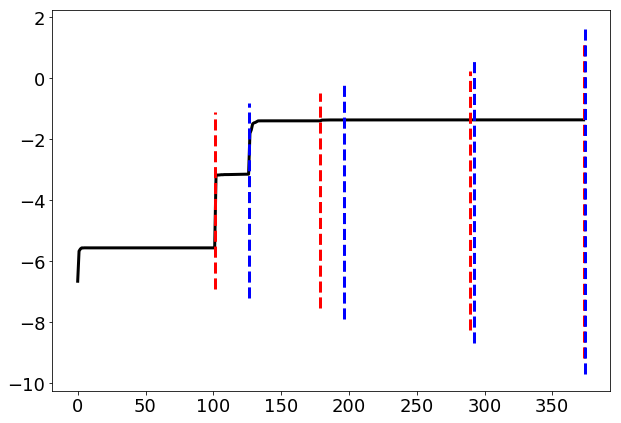

In [16]:
thetas_per_em, alpha_per_em, J1s, J1_grads = optimiser.fit(X, theta0=theta0,
                                                           alpha0=alpha0, 
                                                           disp=True, stop_threshold=10**-5)

In [17]:
thetas_per_em, alpha_per_em

(array([[ 0.        ,  0.5       ],
        [ 0.90187881,  1.38886708],
        [ 2.61148723,  3.88320171],
        [ 2.51697445,  3.92918434],
        [ 2.51697447,  3.9291844 ]]),
 array([[ -1.00000000e-01,  -1.00000000e-01,  -1.00000000e-01],
        [ -2.22760838e-05,  -1.33490042e-06,   2.40797221e-01],
        [ -2.02865752e-06,  -5.66217012e-06,   4.66843776e-01],
        [  1.89559163e-04,  -1.13404166e-05,   4.67551528e-01],
        [  1.89559163e-04,  -1.13404166e-05,   4.67551528e-01]]))

In [21]:
np.exp(-2.51697447), np.exp(-c0)

(0.08070340833206581, 0.079788456080286563)